In [1]:
import json
import uuid
import pandas as pd


import getpass
import os


In [1]:


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [3]:

data = pd.read_excel("responses.xlsx")
data = data[~data['remove_pii_5'].isna()]
data.reset_index(drop=True, inplace=True)
print(f"Number of rows: {data.shape[0]}")

data = data.rename(columns={
                        'remove_pii_1': 'pii_node_1',
                        'remove_pii_2': 'pii_node_2',
                        'remove_pii_3': 'pii_node_3',
                        'remove_pii_4': 'pii_node_4',
                        'remove_pii_5': 'pii_node_5',
                        "Symptoms, Reason to call, Rec": "get_symptoms",
                        "Summarized": "summary"
                        })

error_columns = ['pii_node_1', 'pii_node_2', 'pii_node_3', 'pii_node_4','pii_node_5','get_symptoms', 'summary']

Number of rows: 70


In [4]:
data[error_columns] = data[error_columns].astype(int).astype(bool)

data[error_columns].head()

data['no_errors'] = data[error_columns].all(axis=1)

In [5]:
test_data = data.iloc[0]

In [100]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict, Sequence
from langchain_core.messages import BaseMessage

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("health-chats-graph")

class State(TypedDict):
    batch_id: str
    input: Annotated[Sequence[BaseMessage], operator.add]
    output: Annotated[Sequence[BaseMessage], operator.add]
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [115]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model='claude-3-5-sonnet-20240620')

In [146]:
######## PII ########
# Patient Name, number, email
# Patient ID
# Birthdate
# Medications or prescription
# Policy number and insurance details
# Symptoms
# Summary
#####################

def check_remove_patient_name_number_email(state: State):
    batch_id = state["batch_id"][-1]
    input = state['input'][-1]
    output = state['output'][-1]

    prompt = f"""You are a validator who is diligent and careful. When things are incorrect, you call it out and nothing gets past you.
    Given a input and ouput, your goal is to check if the output followed the directions in the input.

    Special instruction: If the input task was to remove something, but the input didn't have that text and the output was returned as is, please consider that a correct output.
    Example: If the task is to remove a patient's name, but the input didn't mention the patient's name, the output wouldn't have removed the patient's name. In this case this is a correct output
    and the reason is that the input didn't contain the specific text.

    Analyze and output in JSON format with keys: "reason" (the reason why this is correct or incorrect), "check" (1 for correct and 0 for incorrect)

    Input: {input}
    Output: {output}

    """
    response = llm.invoke(prompt)
    return {"batch_id": batch_id,"input": [input], "output":[output], "messages": [response.content]}


In [147]:
from langgraph.graph import StateGraph, Graph, START, END

workflow = StateGraph(State)

workflow.add_node("check_remove_patient_name_number_email", check_remove_patient_name_number_email)

workflow.add_edge(START, "check_remove_patient_name_number_email")
workflow.add_edge("check_remove_patient_name_number_email", END)

graph = workflow.compile()


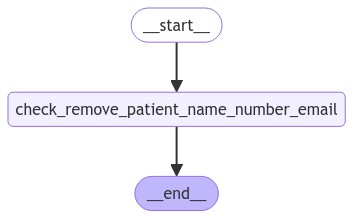

In [148]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

In [153]:
start = 36
end = 70

mappings = [
    ('prompt-1', 'response-1'),
    ('prompt-2', 'response-2'),
    ('prompt-3', 'response-3'),
    ('prompt-4', 'response-4'),
    ('prompt-5', 'response-5'),
    ('prompt-6', 'response-6'),
    ('prompt-7', 'response-7'),
    ]

def write_to_file(batch_id, responses):    
    previous_responses = pd.read_excel("llm-evals.xlsx", sheet_name="Sheet1")
    checks = {f"check-{idx+1}": json.loads(r['messages'][0])['check'] for idx, r in enumerate(responses)}
    reasons = {f"reason-{idx+1}": json.loads(r['messages'][0])['reason'] for idx, r in enumerate(responses)}
    inputs = {f"input-{idx+1}": r["input"][0] for idx, r in enumerate(responses)}
    outputs = {f"output-{idx+1}": r["output"][0] for idx, r in enumerate(responses)}


    checks_pd = pd.DataFrame([{**inputs, **outputs, **checks, **reasons}])  
    checks_pd['batch_id'] = batch_id      
    
    updated_responses = pd.concat([previous_responses, checks_pd])
    updated_responses.to_excel("llm-evals.xlsx", sheet_name="Sheet1", index=False)

for index, row in data[start:end].iterrows():
    json_data = row.to_dict()
    batch_id = json_data['batch_id']

    responses = []
    for mapping in mappings:
        input = json_data.get(mapping[0], None)
        output = json_data.get(mapping[1], None)

        response = graph.invoke({"batch_id": [batch_id], "input": [input], "output": [output]})
        responses.append(response)
    
    try:
        write_to_file(batch_id, responses)
    except Exception as e:
        print(e)



RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your daily rate limit (https://docs.anthropic.com/en/api/rate-limits); see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

# Analysis

In [39]:
llm_outputs = pd.read_excel("llm-evals.xlsx")
llm_outputs = llm_outputs.rename(columns={
                        'remove_pii_1': 'pii_node_1',
                        'remove_pii_2': 'pii_node_2',
                        'remove_pii_3': 'pii_node_3',
                        'remove_pii_4': 'pii_node_4',
                        'remove_pii_5': 'pii_node_5',
                        "Symptoms, Reason to call, Rec": "get_symptoms",
                        "Summarized": "summary"
                        })

error_columns = ['pii_node_1', 'pii_node_2', 'pii_node_3', 'pii_node_4','pii_node_5','get_symptoms', 'summary']

llm_outputs[error_columns] = llm_outputs[error_columns].astype(int).astype(bool)

llm_outputs[error_columns].head()

llm_outputs['no_errors'] = llm_outputs[error_columns].all(axis=1)

In [40]:
class Node:
    def __init__(self, name):
        self.name = name
        self.parents = []

    def add_parent(self, parent):
        self.parents.append(parent)
    
def create_graph():
    nodes = {
        "pii_node_1": Node("pii_node_1"),
        "pii_node_2": Node("pii_node_2"),
        "pii_node_3": Node("pii_node_3"),
        "pii_node_4": Node("pii_node_4"),
        "pii_node_5": Node("pii_node_5"),
        "get_symptoms": Node("get_symptoms"),
        "summary": Node("summary")
    }
    nodes['pii_node_2'].add_parent(nodes['pii_node_1'])
    nodes['pii_node_3'].add_parent(nodes['pii_node_2'])
    nodes['pii_node_4'].add_parent(nodes['pii_node_3'])
    nodes['pii_node_5'].add_parent(nodes['pii_node_4'])
    nodes['get_symptoms'].add_parent(nodes['pii_node_5'])
    nodes['summary'].add_parent(nodes['get_symptoms'])

    return nodes

In [41]:
graph = create_graph()

In [42]:
# Rewritten code

from typing import Dict, List, Tuple

def calculate_probabilities(node: str, data: pd.DataFrame, dependencies: List[Node]) -> Tuple[float, Dict[str, float]]:
    """Calculate failure probabilities for the node and its upstream dependencies."""
    node_fails = data[node] == False
    p_node_fails = node_fails.mean()
    
    # Calculate independent failure probability
    if not dependencies:
        p_independent_fail = p_node_fails
    else:
        deps_pass = data[[dep.name for dep in dependencies]].all(axis=1)
        p_independent_fail = (node_fails & deps_pass).sum() / deps_pass.sum()
    
    # Calculate conditional failure probabilities for dependencies
    p_node_fails_given_dep_fails = {}
    for dep in dependencies:
        dep_fails = data[dep.name] == False

        p_node_fails_given_dep_fails[dep.name] = (node_fails & dep_fails).sum() / dep_fails.sum() if dep_fails.sum() != 0 else 0

        
    return p_node_fails, p_independent_fail, p_node_fails_given_dep_fails

def find_root_cause(node: str, data: pd.DataFrame, graph: Dict[str, Node]) -> Tuple[List[str], float, Dict[str, float]]:
    """Recursively find the root cause of failures, tracing from downstream to upstream."""
    dependencies = graph[node].parents  # These are upstream nodes

    p_node_fails, p_independent_fail, p_node_fails_given_dep_fails = calculate_probabilities(node, data, dependencies)
    
    print(f"Analyzing node: {node}")
    print(f"Overall failure probability for this node: {p_node_fails:.4f}")
    print(f"Independent failure probability: {p_independent_fail:.4f}")
    print(f"Node failure because dep fails: {max([v for _, v in p_node_fails_given_dep_fails.items()])}")
    print(f"Conditional failure probabilities given upstream dependency failures:")
    for dep, prob in p_node_fails_given_dep_fails.items():
        print(f"  P({node} fails | {dep} fails): {prob:.4f}")
    print()
    
    # Check if independent failure is more likely than any upstream dependency failure
    if p_independent_fail > max(p_node_fails_given_dep_fails.values(), default=0) :
        return [node], p_independent_fail, p_node_fails_given_dep_fails

    if not dependencies:
        return [node], p_independent_fail, p_node_fails_given_dep_fails

    max_dep = max(p_node_fails_given_dep_fails, key=p_node_fails_given_dep_fails.get)
    upstream_path, upstream_independent_prob, upstream_final_probs = find_root_cause(max_dep, data, graph)
    
    return [node] + upstream_path, upstream_independent_prob, upstream_final_probs

def improve_system(downstream_node: str, data: pd.DataFrame, graph: Dict[str, Node]) -> Tuple[List[str], float, Dict[str, float]]:
    """Entry point for the root cause analysis, starting from the most downstream node."""
    path, independent_prob, final_probs = find_root_cause(downstream_node, data, graph)
    
    print("\nRoot cause analysis complete.")
    print(f"Debug path (from downstream to upstream): {' -> '.join(path)}")
    print(f"Most likely root cause (most upstream issue): {path[-1]}")
    print(f"Independent failure probability of root cause: {independent_prob:.4f}")
    print("Conditional failure probabilities given root cause's dependency failures:")
    for dep, prob in final_probs.items():
        print(f"  P({path[-1]} fails | {dep} fails): {prob:.4f}")
    
    if independent_prob > max(final_probs.values(), default=0):
        print()
        print(f"The most likely cause is an independent failure in node {path[-1]}")
    else:
        most_likely_dep = max(final_probs.values(), default=0)
        print()
        print(f"The most likely cause is a failure in dependency: {most_likely_dep}")
    
    return path, independent_prob, final_probs

output = improve_system('summary', data=llm_outputs, graph=graph)

Analyzing node: summary
Overall failure probability for this node: 0.0000
Independent failure probability: 0.0000
Node failure because dep fails: 0
Conditional failure probabilities given upstream dependency failures:
  P(summary fails | get_symptoms fails): 0.0000

Analyzing node: get_symptoms
Overall failure probability for this node: 0.0000
Independent failure probability: 0.0000
Node failure because dep fails: 0
Conditional failure probabilities given upstream dependency failures:
  P(get_symptoms fails | pii_node_5 fails): 0.0000

Analyzing node: pii_node_5
Overall failure probability for this node: 0.0000
Independent failure probability: 0.0000
Node failure because dep fails: 0.0
Conditional failure probabilities given upstream dependency failures:
  P(pii_node_5 fails | pii_node_4 fails): 0.0000

Analyzing node: pii_node_4
Overall failure probability for this node: 0.0727
Independent failure probability: 0.0727
Node failure because dep fails: 0
Conditional failure probabilities 